# Basics

This example demonstrates the basics of neural operators in Continuity,
including how to train it on a given operator.

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from continuity.operators import DeepONet
from continuity.data import OperatorDataset

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Problem

Let's assume we want to learn the derivative operator
$$
G: u \mapsto v = \partial_x u.
$$
We choose (as an example) $u(x) = \sin(x)$, and thus $v(x) = \cos(x)$,
on the interval $[-\pi, \pi]$.

Let's start with defining and plotting input and target function!

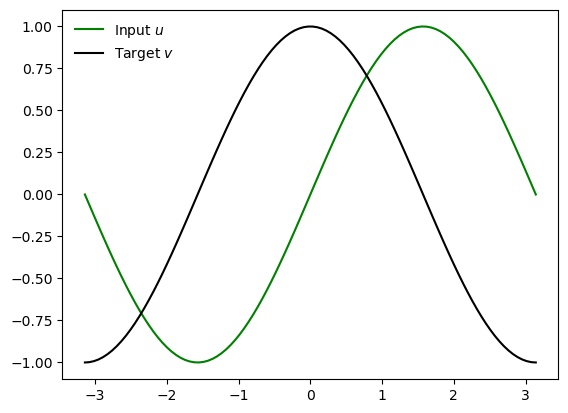

In [3]:
# Input function (some example)
u = lambda x: torch.sin(x)

# Target function (the derivative of u)
v = lambda y: torch.cos(y)

# Dataset contains discrete instances of the continuous functions
L = torch.pi
num_sensors = 32
num_evaluations = 100
x = torch.linspace(-L, L, num_sensors)
y = torch.linspace(-L, L, num_evaluations)  # here the domain of the derivative is the same as the domain of the function

# This dataset contains only a single sample (first dimension of all tensors)
n_observations = 1
u_dim = x_dim = y_dim = v_dim = 1
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)
data_loader = DataLoader(dataset)

# Plot input and target function
plt.plot(y, u(y), "g-", label="Input $u$")
plt.plot(y, v(y), "k-", label="Target $v$")
plt.legend()
plt.show()

## Operator

To learn operator $G$ with a neural network, we can train a _neural operator_.

A neural operator takes an input function $u$, evaluated at collocation points $x$,
and maps it to a function $v$ evaluated at (different) evaluation positions $y$:
$$
v(y) = G(u)(y) \approx G_\theta\left(x, u(x), y\right).
$$
In this example, we choose the DeepONet architecture with 32 sensors as neural
operator.

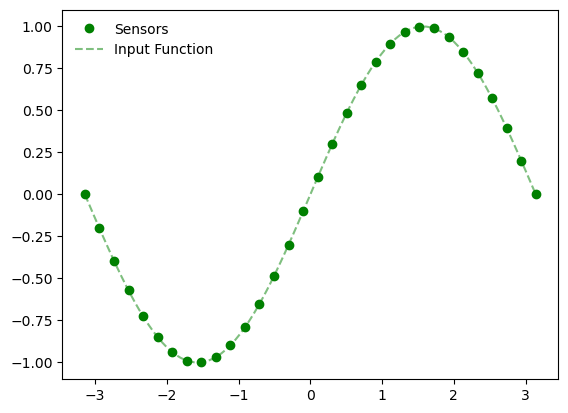

In [4]:
# Define operator
operator = DeepONet(dataset_shape=dataset.shape)

# Plot sensors
plt.plot(x, u(x), "go", label="Sensors")
plt.plot(y, u(y), "g--", alpha=0.5, label="Input Function")
plt.legend()
plt.show()

## Plotting

Before we train the neural operator, let us show how to evaluate the (untrained)
neural operator and plot the result.

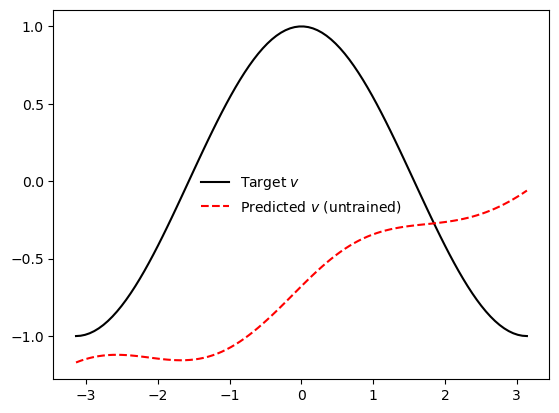

In [5]:
# Call operator
x, u, y, v = dataset[:]
v_pred = operator(x, u, y)

# Plot the predicted function
plt.plot(y.squeeze(), v.squeeze(), "k-", label="Target $v$")
plt.plot(y.squeeze(), v_pred.detach().squeeze(), "r--", label="Predicted $v$ (untrained)")
plt.legend()
plt.show()

## Training

Now, let's train the neural operator!

We define a corresponding data set, i.e., a list-like of input-output samples.

Using Adam, we train the neural operator for 1000 epochs. 

In [6]:
optimizer = torch.optim.Adam(operator.parameters(), lr=1e-3)
operator.compile(optimizer)
operator.fit(data_loader, epochs=1000)

Model parameters: 60256
Epoch 1000:  loss/train = 7.3273e-04  (0.00 s/epoch)


## Evaluating

The mapping of the trained operator can be evaluated at arbitrary positions,
so let's plot with a fine resolution along with the target function.

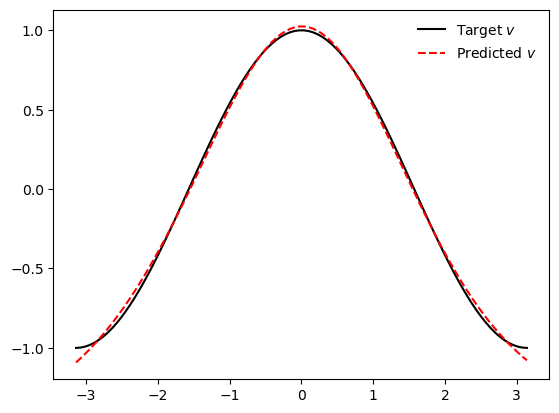

In [7]:
# Call operator with more points
v_pred = operator(x, u, y).squeeze()

# Plot output and target function
plt.plot(y.squeeze(), v.squeeze(), "k-", label="Target $v$")
plt.plot(y.squeeze(), v_pred.detach(), "r--", label="Predicted $v$")
plt.legend()
plt.show()

As you can see, the operator output (approximately) matches $v$, as desired.
That's the basics!

In the other examples, we explore advanced features such as 
physics-informed training, self-supervised training, or super-resolution.